In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [48]:
healthy=[]
path="./data/brain_tumor_dataset/no/*.jpg"
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    healthy.append(img)

In [49]:
tumor=[]
path="./data/brain_tumor_dataset/yes/*.jpg"
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    tumor.append(img)

In [50]:
healthy,tumor=np.array(healthy),np.array(tumor)

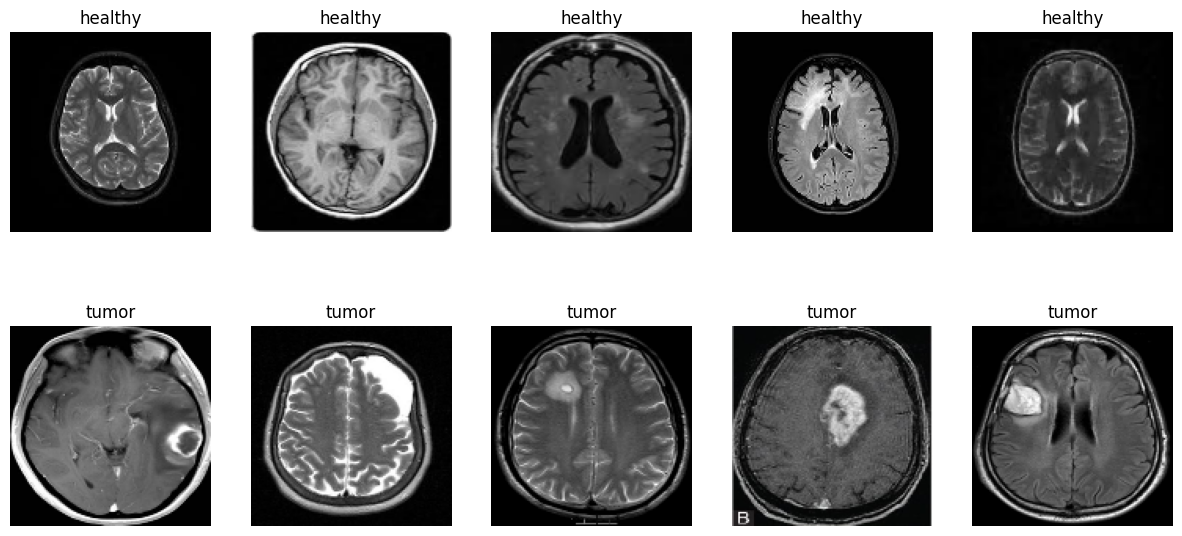

In [51]:
def plot_random(healthy,tumor,num=5):
    healthy_images=healthy[np.random.choice(len(healthy),num,replace=False)]
    tumor_images=tumor[np.random.choice(len(tumor),num,replace=False)]
    plt.figure(figsize=(15,7))
    for i in range(num):
        plt.subplot(2,num,i+1)
        plt.imshow(healthy_images[i])
        plt.title("healthy")
        plt.axis("off")
        plt.subplot(2,num,num+i+1)
        plt.imshow(tumor_images[i])
        plt.title("tumor")
        plt.axis("off")
plot_random(healthy,tumor)

In [52]:
input_dir="./data/brain_tumor_dataset/"

In [53]:
import os
from os import listdir
listdir(input_dir)

['no', 'yes']

In [54]:
os.makedirs("/Users/Jaganath/deep learning/brain_mri_tumor_detection/data_aug",exist_ok=True)
os.makedirs('/Users/Jaganath/deep learning/brain_mri_tumor_detection/data_aug/yes',exist_ok=True)  
os.makedirs('/Users/Jaganath/deep learning/brain_mri_tumor_detection/data_aug/no',exist_ok=True)

In [55]:
from PIL import ImageEnhance
from PIL import Image
import random
def apply_augmentation(image):
    
    angle=random.randint(-10,10)
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    return augmented_image

In [56]:
output_dir="/Users/Jaganath/deep learning/brain_mri_tumor_detection/data_aug"
for files in listdir(input_dir):
    for file in listdir(input_dir+files):
        if(file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png")):
            input_path=os.path.join(input_dir+files,file)
            image=Image.open(input_path)
            
            if (files=="no"):
                for i in range(3):
                        augmented_image=apply_augmentation(image)
                        output_file=f"{os.path.splitext(file)[0]}_{i}.png"
                        output_path=os.path.join(output_dir+"/"+files,output_file)
                        augmented_image.save(output_path)
            elif(files=="yes"):
                for i in range(5):
                        augmented_image=apply_augmentation(image)
                        output_file=f"{os.path.splitext(file)[0]}_{i}.png"
                        output_path=os.path.join(output_dir+"/"+files,output_file)
                        augmented_image.save(output_path)

In [57]:
root_dir="/Users/Jaganath/deep learning/brain_mri_tumor_detection/data_aug"

In [58]:
class CustomDataSet(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.images=[]
        self.labels=[]
        for subdir,i,files in os.walk(root_dir):
            for file in files:
                 if(file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
                        self.images.append(os.path.join(subdir,file))
                        label=1 if "yes" in subdir else 0
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        image_path=self.images[idx]
        image=Image.open(image_path).convert("L")
        if(self.transform):
            image=self.transform(image)
        label=self.labels[idx]
        return image,label

In [59]:
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485],[0.229]),
])

In [60]:
train_test_dataset=CustomDataSet(root_dir=root_dir,transform=transform)

In [61]:
len(train_test_dataset)

706

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_size=0.7
test_size=0.15
valid_size=0.15
total_data=len(train_test_dataset)
indices=list(range(total_data))
train_indices, test_indices = train_test_split(indices, test_size=(test_size + valid_size),random_state=42) #splitting into train and test
print(f"the number of total indices {len(indices)}\n number of train indices {len(train_indices)}\n number of test indices {len(test_indices)}\n")

train_dataset=Subset(train_test_dataset,train_indices)
test_dataset=Subset(train_test_dataset,test_indices)

the number of total indices 706
 number of train indices 494
 number of test indices 212



In [63]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [64]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)

        return out

In [65]:
class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

            
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        
        out = self.relu(out)

        return out
    

In [66]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [67]:
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [68]:
model = resnet18().to(device)

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
scaler = torch.cuda.amp.GradScaler()

In [71]:
def train(model,train_loader,optimizer,loss_fn):
    
    model.train()
    train_loss,train_accuracy=0,0
    correct=0
    total=0
    
    for images,labels in train_loader:
        
        outputs=model(images.to(device))
        loss=loss_fn(outputs,labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        train_accuracy += (torch.argmax(outputs,dim=1) == labels.to(device)).sum().item()/len(outputs)
        
    #train_accuracy=100*correct/total
    train_loss/=len(train_loader)
    train_accuracy=train_accuracy/len(train_loader)
    return train_loss,train_accuracy*100

In [72]:
def test(model,test_loader,loss_fn):
    model.eval()
    test_loss=0
    test_accuracy=0
    correct=0
    total=0
    
    with torch.no_grad():
        for images,labels in test_loader:
            
            outputs=model(images.to(device))
            loss=loss_fn(outputs,labels.to(device))
            
            test_loss+=loss.item()
            test_accuracy += (torch.argmax(outputs,dim=1) == labels.to(device)).sum().item()/len(outputs)
            
        test_accuracy = test_accuracy/len(test_loader)
        test_loss /= len(test_loader)
    return test_loss, test_accuracy*100


In [73]:
from tqdm.auto import tqdm
train_losses,train_accs,test_losses,test_accs=[],[],[],[]
for epoch in tqdm(range(11)):    
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    
    test_loss, test_acc = test(model, test_loader, loss_fn)
    if epoch%2==0: 
        print(f"train loss{train_loss}|train acc:{train_acc}\ntest loss {test_loss} test acc{test_acc}\n")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

  9%|▉         | 1/11 [00:33<05:35, 33.54s/it]

train loss1.8600315432995558|train acc:68.83370535714286
test loss 3.0473252534866333 test acc56.69642857142857



 27%|██▋       | 3/11 [01:22<03:33, 26.68s/it]

train loss0.36544845160096884|train acc:83.81696428571429
test loss 1.707776665687561 test acc58.92857142857143



 45%|████▌     | 5/11 [02:12<02:33, 25.51s/it]

train loss0.15148838295135647|train acc:95.5078125
test loss 0.6500813471419471 test acc83.30357142857142



 64%|██████▎   | 7/11 [03:02<01:40, 25.08s/it]

train loss0.13254612241871655|train acc:94.75446428571429
test loss 0.28666406869888306 test acc86.25



 82%|████████▏ | 9/11 [03:51<00:49, 24.91s/it]

train loss0.1310143657028675|train acc:94.3359375
test loss 1.2279155892985207 test acc68.92857142857143



100%|██████████| 11/11 [04:36<00:00, 25.12s/it]

train loss0.06066959575400688|train acc:97.60044642857143
test loss 0.3073620934571539 test acc93.39285714285714



In [80]:
train_accs

[68.83370535714286,
 79.82700892857143,
 83.81696428571429,
 91.48995535714286,
 95.5078125,
 96.484375,
 94.75446428571429,
 92.71763392857143,
 94.3359375,
 97.8515625,
 97.60044642857143]

In [81]:
test_accs

[56.69642857142857,
 57.14285714285714,
 58.92857142857143,
 77.67857142857143,
 83.30357142857142,
 95.89285714285715,
 86.25,
 94.10714285714286,
 68.92857142857143,
 96.07142857142857,
 93.39285714285714]

In [76]:
test_losses

[3.0473252534866333,
 3.883254017148699,
 1.707776665687561,
 0.7547899484634399,
 0.6500813471419471,
 0.10473396575876645,
 0.28666406869888306,
 0.16234902585191385,
 1.2279155892985207,
 0.1315141777907099,
 0.3073620934571539]

In [82]:
train_losses

[1.8600315432995558,
 0.40414615720510483,
 0.36544845160096884,
 0.24227648880332708,
 0.15148838295135647,
 0.10750718507915735,
 0.13254612241871655,
 0.15542393224313855,
 0.1310143657028675,
 0.08303172187879682,
 0.06066959575400688]

In [83]:
epochs=list(range(1, 12))

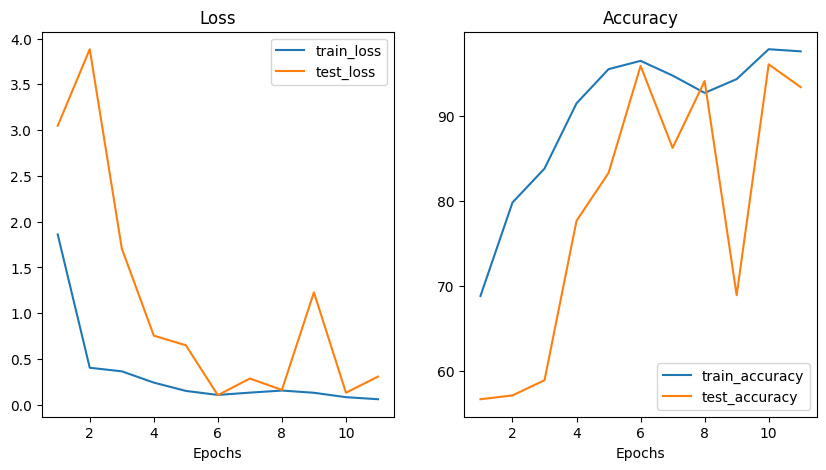

In [108]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='train_loss')
plt.plot(epochs, test_losses, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='train_accuracy')
plt.plot(epochs, test_accs, label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [85]:
torch.save(model.state_dict(), 'resnet18_brain_tumor.pth')

In [105]:
def predict_image(image_path, model, device, transform):
    image = Image.open(image_path).convert("L") 
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()[0]
    class_labels = ['Healthy', 'Tumor']
    predicted_label = class_labels[predicted]
    
    return predicted_label


In [109]:
# Loading the trained model
model = resnet18().to(device)
model.load_state_dict(torch.load('resnet18_brain_tumor.pth', map_location=device))

image_path = './data/brain_tumor_dataset/no/6 no.jpg' 
predicted_label = predict_image(image_path, model, device, transform)
print(f'The predicted label for the image is: {predicted_label}')


The predicted label for the image is: Healthy
